# [Open in Google Colab](https://colab.research.google.com/github/Jechen00/yolov1-pytorch/blob/main/notebooks/yolov1_predictions.ipynb)

# Packages and Dependencies


In [1]:
from IPython.display import clear_output
import torch
import os, sys
import random
import yaml, pickle

# Importing torchmetrics
try:
    import torchmetrics
except:
    print('\033[1m[ALERT]\033[0m torchmetrics not found. Installing with pip...')
    !pip install torchmetrics

# Check if running in Google Colab
try:
    import google.colab
    print('\033[1m[ALERT]\033[0m Running in Google Colab.')
    IN_COLAB = True
    repo_path = './yolov1-pytorch'

except ImportError:
    print('\033[1m[ALERT]\033[0m Running in yolov1-pytorch repository.')
    IN_COLAB = False
    repo_path = '..'

# Clone repo if it doesn't exist
if IN_COLAB and (not os.path.exists(repo_path)):
    print('\033[1m[ALERT]\033[0m Repository not found. Cloning yolov1-pytorch from GitHub...')
    !git clone https://github.com/Jechen00/yolov1-pytorch.git
        
# Import repo modules
sys.path.append(os.path.abspath(repo_path))
from src import constants, data_setup, models
from src.utils import plot

clear_output(wait = True) # Clear the cluttered output after setup
print(f'\033[1mDevice:\033[0m {constants.DEVICE}')

# Load Saved Model

The model we are loading was trained with the default `config.yaml` file for **150 epochs.**

The model was also saved on **CPU**.

In [2]:
save_base = repo_path + '/saved_models/yolov1_resnet50'

state_dict = torch.load(f'{save_base}_model.pth') # Model weights

with open(f'{save_base}_configs.yaml', 'r') as f:
    configs = yaml.safe_load(f) # Model configs (Doesn't include ResNet50 backbone)
    
with open(f'{save_base}_results.pkl', 'rb') as f:
    res = pickle.load(f) # Training results (loss and eval metrics)

In [3]:
# Create YOLOv1 model
backbone = models.build_resnet50_backbone()
yolov1 = models.YOLOv1(backbone = backbone,
                       **configs)

yolov1.load_state_dict(state_dict)
yolov1 = yolov1.to(constants.DEVICE)

# Get Dataset

In [4]:
data_dir = repo_path + '/data'
    
    
transforms = data_setup.get_transforms(train = False)
MAX_IMGS = None

val_dataset = data_setup.VOCDataset(root = data_dir,
                                    train = False, transforms = transforms,
                                    S = yolov1.S, B = yolov1.B,
                                    max_imgs = MAX_IMGS)

# Plotting Results

The mAP scores are from `obj_threshold = 0.2`, `nms_threshold = 0.5`, and `map_thresholds = [0.5`.

Final mAP: 0.5690679550170898


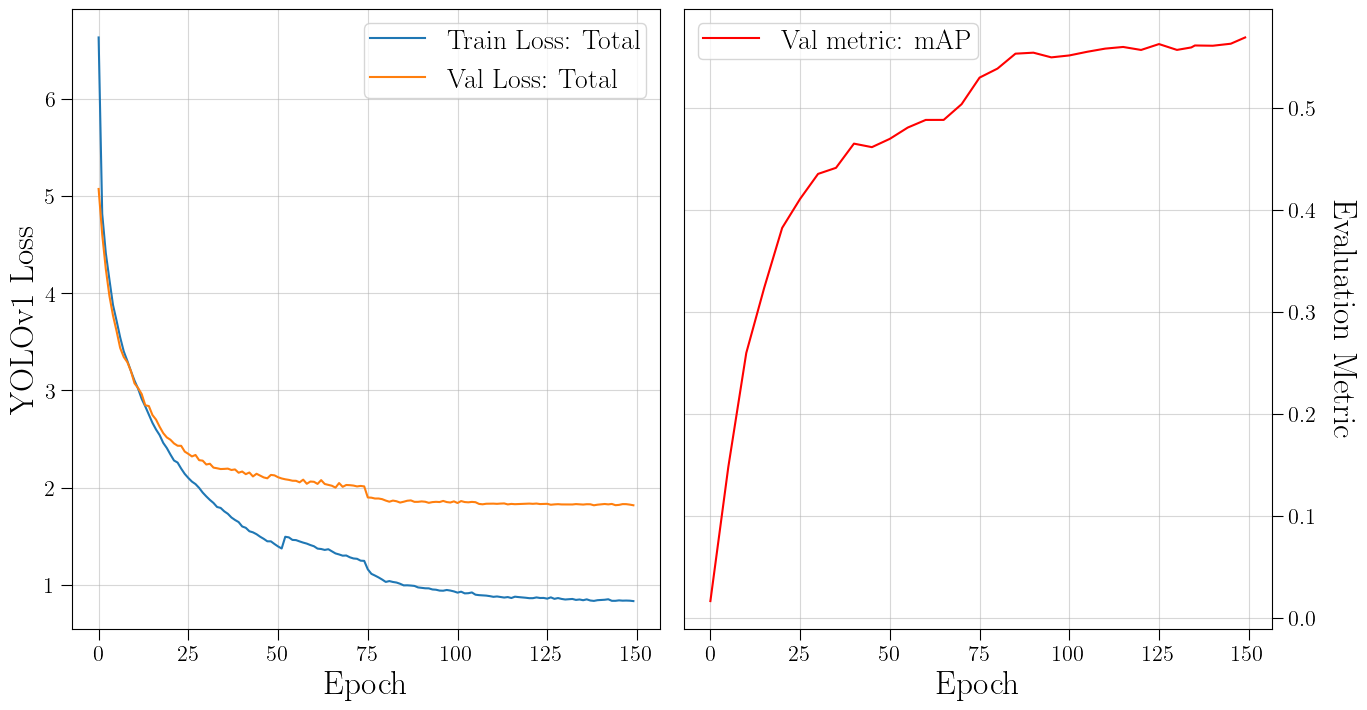

In [5]:
# Plot losses and eval metrics from training
train_losses = res['train_losses']
val_losses = res['val_losses']

eval_history = res['eval_history']
map_scores = [eval_history[key]['map'] for key in eval_history]
print(f'Final mAP: {map_scores[-1]}')

plot.plot_results(train_losses, val_losses, eval_history,
                  loss_key = 'total', eval_key = 'map')

# Predictions

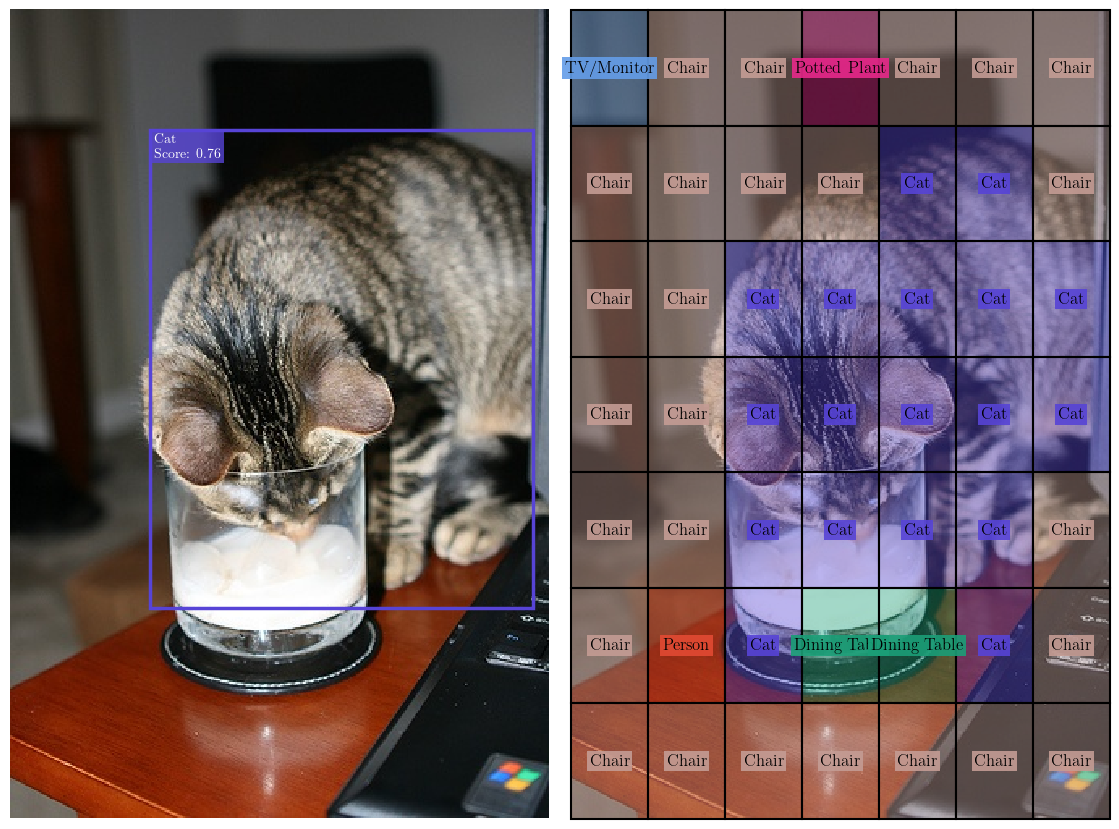

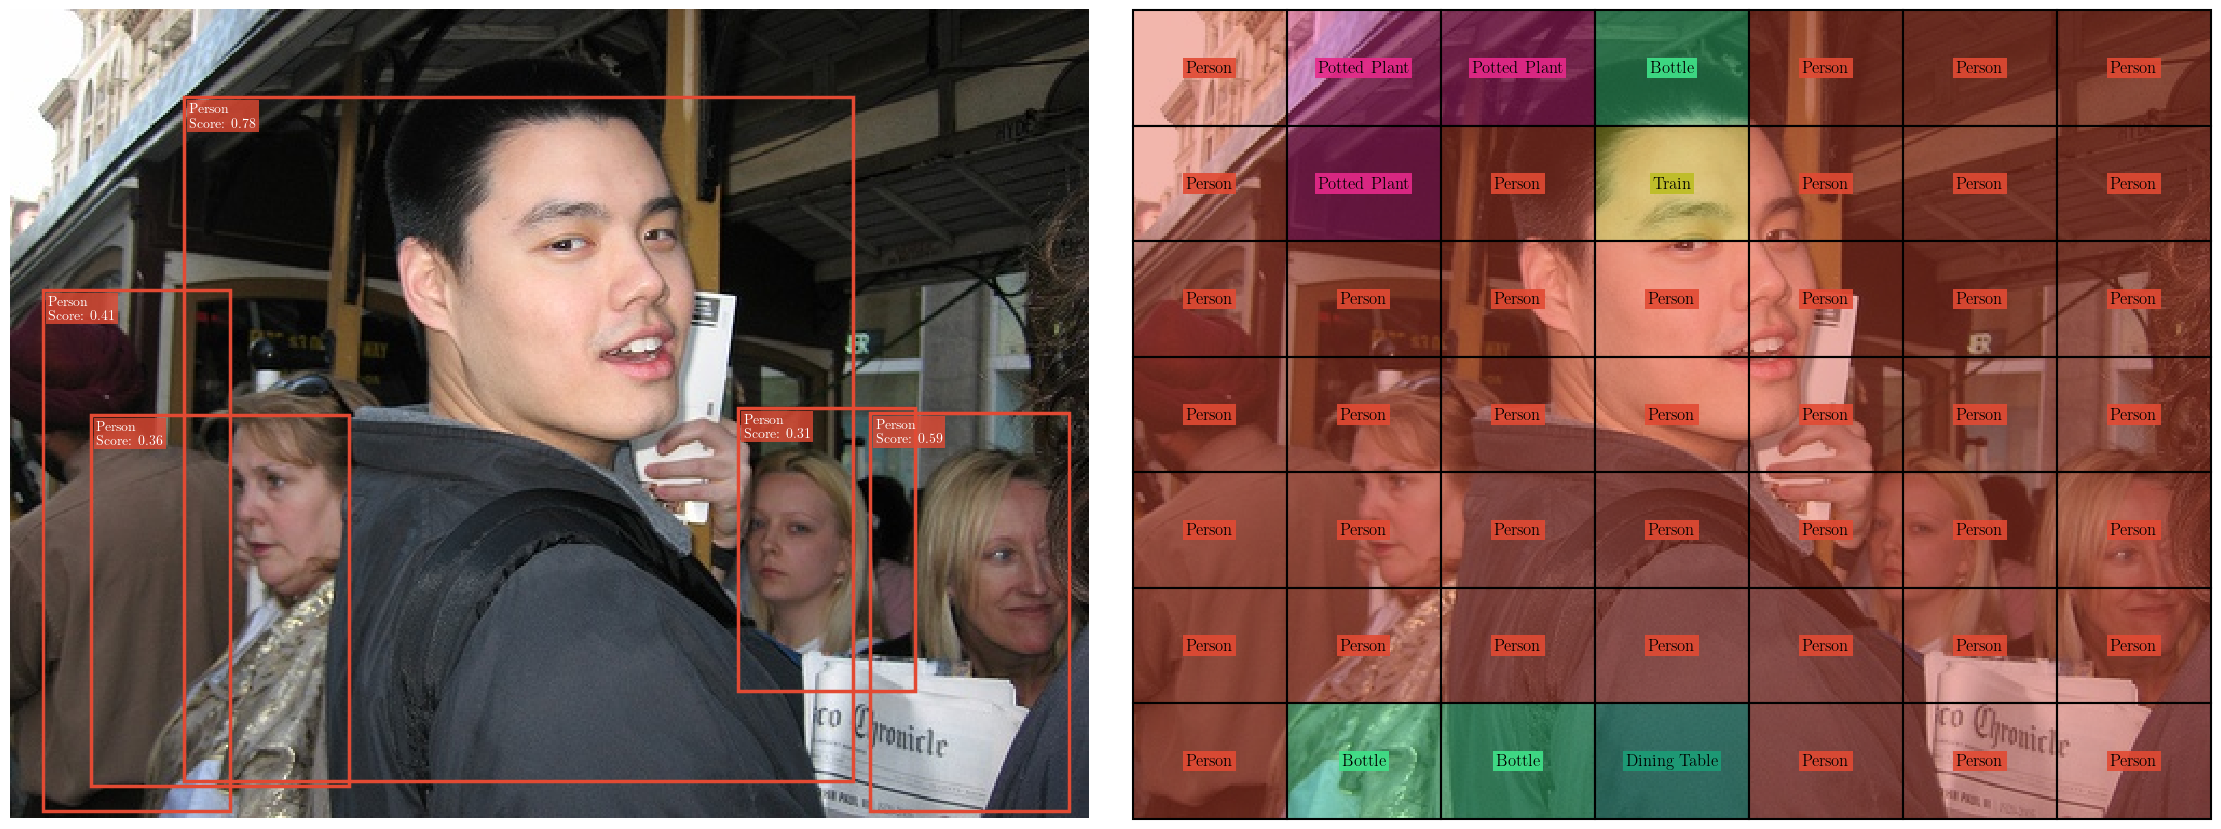

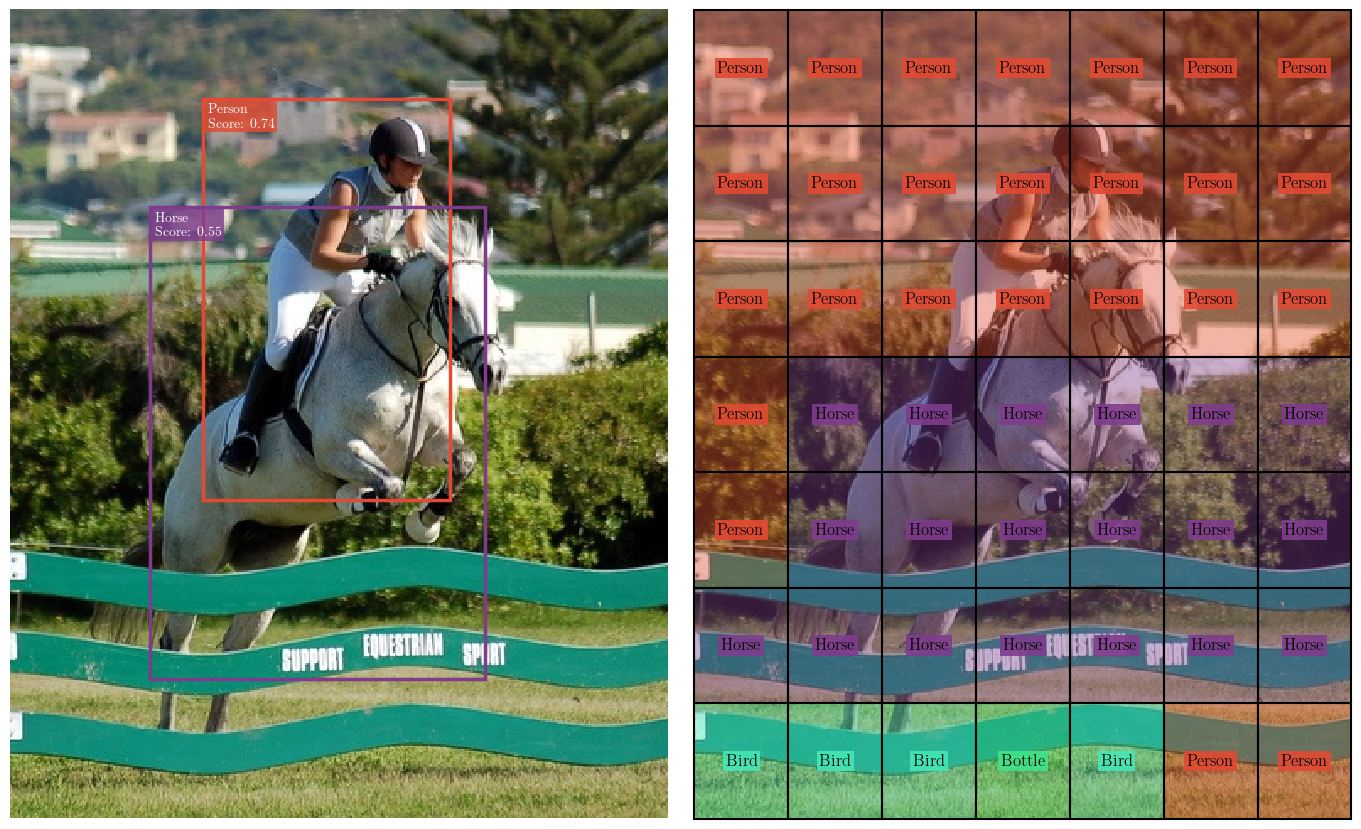

In [6]:
# Prediction Configs
OBJ_THRESHOLD = 0.25
NMS_THRESHOLD = 0.5

# IMG_RESIZE = (448, 448)
IMG_RESIZE = None

SHOW_SCORES = True
SHOW_PROBS = False

NUM_SAMPLES = 3

# Plotting Predictions
transforms = data_setup.get_transforms(train = False)
sample_idxs = random.sample(range(len(val_dataset)), NUM_SAMPLES)

for i in sample_idxs:
    img = val_dataset.get_img(i)

    fig = plot.draw_preds_yolov1(yolov1, img, transforms,
                                 OBJ_THRESHOLD, NMS_THRESHOLD,
                                 IMG_RESIZE,
                                 SHOW_SCORES, SHOW_PROBS,
                                 device = constants.DEVICE)
    display(fig)